# Exercise 5: Simulation of dynamic models of gene expression and regulation (DL 13 October)

Lecturer: Antti Honkela

Your name: Bella Zhukova

Name of your pair: Christian Koetsier

In this exercise you will implement simulators to simulate biochemical reaction systems similar to ones that could be used to simulate gene expression.

## Task 1: Discrete event simulation I: Simple systems (2 points)

In this task your aim is to perform stochastic simulation of simple discrete reaction systems with a single species X in different scenarios. Each scenario comes with a number of questions. Please answer these by having your code print out the answers.

### a) Simulate the decay of a population of 100 individuals with decay rate 1.

The corresponding reaction system is:
$$ X \rightarrow \emptyset $$

* Implement a function that runs the simulation.
* Repeat the simulation 100 times. What is the average time until extinction? What are the minimum and maximum times?
* What is the mean and standard deviation of the number of individuals left alive after 1 unit of time?
* Plot the simulated numbers of individuals as function of time together in a single plot.

Hints:
* numpy.random (imported as npr) has many useful functions for simulating random variables with specific distributions, e.g. npr.exponential and npr.choice (for subtasks b and c)

N0: 100 | rate: 1 | number of steps: 100 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Time until extinction:
 - max =  11.0077204533
 - min =  2.99635394334
 - average =  5.40160703191 

Number of individuals left alive after 1 unit of time:
 - mean =  35.53
 - standard deviation =  5.13313744215 



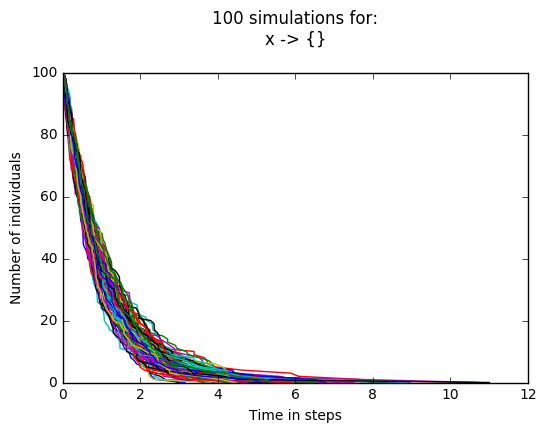

N0: 100 | rate: 0.1 | number of steps: 100 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Time until extinction:
 - max =  102.339356688
 - min =  29.8238075289
 - average =  50.8380319852 

Number of individuals left alive after 1 unit of time:
 - mean =  89.84
 - standard deviation =  3.31879496203 



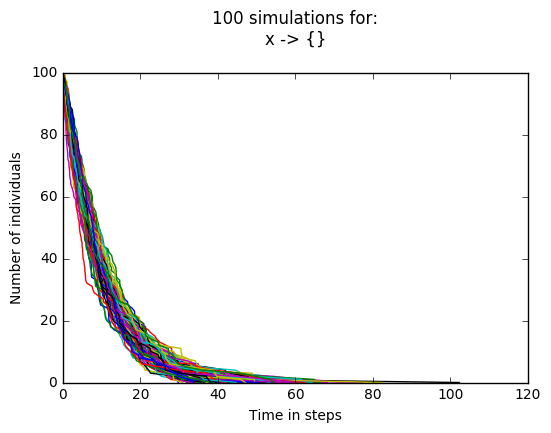

In [4]:
%matplotlib inline
# Import some useful modules
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
from scipy.special import comb

# Suggested structure: simulate the decay of a population of N0 individuals at rate 'rate' for 'numsteps' steps
def simulate_decay(N0, rate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        h = Nhist[i]
        a = h * rate
        a0 = a   
        # Algorithm - Step 2
        tau = npr.exponential(1/a0)
        # Algorithm - Step 3
        Nhist[i + 1] = Nhist[i] - 1
        Thist[i + 1] = Thist[i] + tau
    return (Thist, Nhist)


# Repeat the simulation
def run_scenario_1a(N0, rate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| rate:', rate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    timeEnds = []
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_decay(N0, rate, steps_number)
        timeEnds.append(Thist[-1])
        alive.append(Nhist[next(index for index,value in enumerate(Thist) if value > 1)])
        if showPlot: plt.plot(Thist, Nhist) 

    # What is the average time until extinction? What are the minimum and maximum times?
    print('Time until extinction:')
    print(' - max = ', np.max(timeEnds))
    print(' - min = ', np.min(timeEnds))
    print(' - average = ', np.mean(timeEnds), '\n')

    # What is the mean and standard deviation of the number of individuals left alive after 1 unit of time?
    print('Number of individuals left alive after 1 unit of time:')
    print(' - mean = ', np.mean(alive))
    print(' - standard deviation = ', np.std(alive), '\n')
    
    if showPlot: 
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()
    
# Format: (N0, rate, numsteps, simulationRepeats, showPlot)    
run_scenario_1a(100, 1, 100, 100, True)
# Format: (N0, rate, numsteps, simulationRepeats, showPlot)    
run_scenario_1a(100, 0.1, 100, 100, True)

# TODO: Check values with other groups!

### b) Simulate a birth-death process of a population of 100 individuals with decay rate 1 and birth rates [0.8, 1, 1.2] for 10000 steps.

The corresponding reaction system is:
\begin{align}
X &\rightarrow 2X \\
X &\rightarrow \emptyset \\
\end{align}

* Implement a function that runs the simulation.
* Repeat each simulation 100 times. How many simulations lead to extinction in each scenario? What are the statistics of the final populations in each scenario (mean, min, max)?


In [56]:
def simulate_birthdeath(N0, birthrate, deathrate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        a1 = N * birthrate
        a2 = N * deathrate
        a0 = a1 + a2
        
        # Stop: no reaction could occur
        if a0 == 0:
            break
        
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)
        if r2 == 0:
            mu = 1    # in order not to have a check: 0 < 0 and 0 <= a1
        else:
            partial_sums = np.cumsum([0, a1, a2])
            mu = next(index for index,value in enumerate(partial_sums) if index > 0 and partial_sums[index - 1] < r2 * a0 and r2 * a0 <= partial_sums[index])
                
        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau
        N = N + 1 if mu == 1 else N - 1   # if mu == 1 => birth, if mu == 2 => death
        Nhist[i+1] = N
    return (Thist, Nhist)


# Repeat each simulation 100 times. 
# How many simulations lead to extinction in each scenario? 
# What are the statistics of the final populations in each scenario (mean, min, max)?
def run_scenario_1b(N0, birthrate, deathrate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| birth rate:', birthrate, '| death rate:', deathrate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_birthdeath(N0, birthrate, deathrate, steps_number)
        alive.append(Nhist[-1])
        if showPlot: plt.plot(Thist, Nhist)
        
    # Population is called "extincted" if final population is of size 0
    print('Simulations lead to extinction =', alive.count(0))
    print('Final population statistics:\n - mean = ', np.mean(alive), '\n - min = ', np.min(alive), '\n - max = ', np.max(alive), '\n')
    
    if showPlot:
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\nx -> 2x\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()

# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 0.8, 1.0, 10000, 100, True)
# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 1.0, 1.0, 10000, 100, True)
# Format: (N0, birthrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1b(100, 1.2, 1.0, 10000, 100, True)

# TODO: Check values with other groups!

N0: 100 | birth rate: 0.8 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 100
Final population statistics:
 - mean =  0.0 
 - min =  0.0 
 - max =  0.0 

N0: 100 | birth rate: 1.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 31
Final population statistics:
 - mean =  91.3 
 - min =  0.0 
 - max =  300.0 

N0: 100 | birth rate: 1.2 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 0
Final population statistics:
 - mean =  1012.82 
 - min =  752.0 
 - max =  1280.0 



### c) Simulate a migration-death process of a population of 100 individuals with decay rate 1 and migration rates [1.0, 10.0, 100.0] for 10000 steps.

The corresponding reaction system is:
\begin{align}
\emptyset &\rightarrow X \\
X &\rightarrow \emptyset \\
\end{align}

* Implement a function that runs the simulation.
* Repeat each simulation 100 times. How many simulations lead to extinction in each scenario? What are the statistics of the final populations in each scenario (mean, min, max)?


In [46]:
def simulate_migrationdeath(N0, migrationrate, deathrate, numsteps):
    # Current population size
    N = N0
    # Current time
    t_cur = 0
    # History of population size across the simulation
    Nhist = np.zeros(numsteps+1)
    Nhist[0] = N
    # Times of the corresponding population sizes
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        a1 = 1 * migrationrate
        a2 = N * deathrate
        a0 = a1 + a2
                
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)
        if r2 == 0:
            mu = 1    # in order not to have a check: 0 < 0 and 0 <= a1
        else:
            partial_sums = np.cumsum([0, a1, a2])
            mu = next(index for index,value in enumerate(partial_sums) if index > 0 and partial_sums[index - 1] < r2 * a0 and r2 * a0 <= partial_sums[index])
                
        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau   
        N = N + 1 if mu == 1 else N - 1   # if mu == 1 => migration, if mu == 2 => death
        Nhist[i+1] = N
    return (Thist, Nhist)


# Repeat each simulation.
# How many simulations lead to extinction in each scenario? 
# What are the statistics of the final populations in each scenario (mean, min, max)?
def run_scenario_1c(N0, migrationrate, deathrate, steps_number, simulationRepeats, showPlot):
    print('N0:', N0, '| migration rate:', migrationrate, '| death rate:', deathrate, '| number of steps:', steps_number, '| simulation repeats:', simulationRepeats)
    print('----------------------------------------------------------------------------------------------------')
    alive = []
    for i in range(simulationRepeats):
        Thist, Nhist = simulate_migrationdeath(N0, migrationrate, deathrate, steps_number)
        alive.append(Nhist[-1])
        if showPlot: plt.plot(Thist, Nhist)
        
    # Population is called "extincted" if final population is of size 0
    print('Simulations lead to extinction =', alive.count(0))
    print('Final population statistics:\n - mean = ', np.mean(alive), '\n - min = ', np.min(alive), '\n - max = ', np.max(alive), '\n')
    
    if showPlot:
        # Plot the data
        plt.title(str(simulationRepeats) + ' simulations for:\n{} -> x\nx -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()

# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 1.0, 1.0, 10000, 100, False)
# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 10.0, 1.0, 10000, 100, False)
# Format: (N0, migrationrate, deathrate, numsteps, simulationRepeats, showPlot)
run_scenario_1c(100, 100.0, 1.0, 10000, 100, False)

N0: 100 | migration rate: 1.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 33
Final population statistics:
 - mean =  1.54 
 - min =  0.0 
 - max =  4.0 

N0: 100 | migration rate: 10.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 0
Final population statistics:
 - mean =  10.56 
 - min =  4.0 
 - max =  22.0 

N0: 100 | migration rate: 100.0 | death rate: 1.0 | number of steps: 10000 | simulation repeats: 100
----------------------------------------------------------------------------------------------------
Simulations lead to extinction = 0
Final population statistics:
 - mean =  101.36 
 - min =  78.0 
 - max =  120.0 



Briefly summarise how each model behaves qualitatively in the text area below:

TODO: !!!

## Task 2: Discrete event simulation II: The general case (3 points)

### a) Implement the general Stochastic Simulation Algorithm of Gillespie (1977).

* Implement a function that runs the simulator.
* Test your simulator by re-implementing exercises 1a and 1b to make sure your results are similar.

In [27]:
import scipy.special as ssp

# Suggested skeleton for the simulation algorithm
# Suggested arguments are NumPy arrays with sizes as follows:
# inputs: [reactions x state]
# outputs: [reactions x state]
# rates: [reactions]
def stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    # Implementation of the stochastic simulation algorithm (Gillespie 1977, figure 2)
    for i in range(numsteps):
        # Algorithm - Step 1
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                h[j] *= ssp.binom(state[k], inputs[j][k])
        a = h * rates
        a0 = sum(a)
        
        # Stop: no reaction could occur
        if a0 == 0:
            break
            
        # Algorithm - Step 2
        r1, r2 = npr.random(2)
        while r1 == 0:
            r1 = npr.random(1)
        tau = (1/a0) * np.log(1/r1)
        
        # TODO: We do not have to check r2 == 0 as in 1b/c? >>> Change 1b/c accordingly!
        partial_sums = np.cumsum(a)
        # Which reaction occurred, mu in [0, M-1]
        mu = next(index for index,value in enumerate(partial_sums) if (True if index == 0 else partial_sums[index - 1] < r2 * a0) and r2 * a0 <= partial_sums[index])
        
        # Algorithm - Step 3
        Thist[i + 1] = Thist[i] + tau  
        for k in range(N):
            state[k] -= inputs[mu][k]
            state[k] += outputs[mu][k]
        Nhist[i+1,:] = state
    return (Thist, Nhist)

### b) Use your simulator to simulate the Lotka-Volterra predator-prey system:
\begin{align}
X_1 + X_2 &\rightarrow 2 X_1 \quad &\text{# Predator-prey interaction} \\
X_2 &\rightarrow 2 X_2 &\text{# Prey reproduction} \\
X_1 &\rightarrow \emptyset &\text{# Predator death} \\
\end{align}

* Try to find rates for the different equations that produce interesting behaviour.
* Plot examples of the behaviour under different rates.

rates: [  0.1  10.   10. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  209.0
Prey population:  27.0


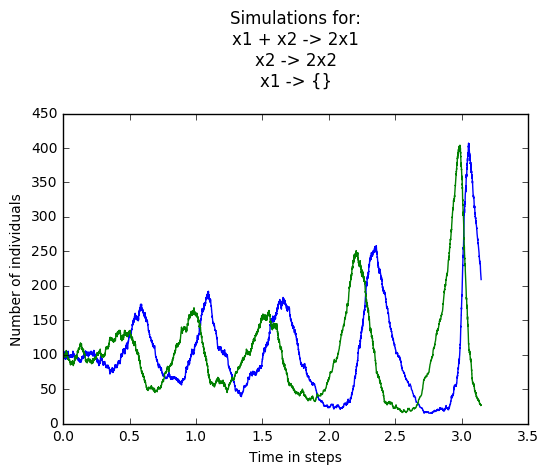

rates: [   0.1  100.     1. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  1889.0
Prey population:  0.0


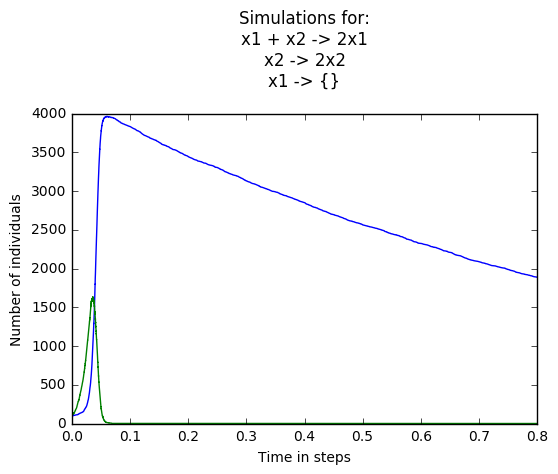

rates: [  0.1   5.   10. ] | numsteps: 10000
----------------------------------------------------------------------------------------------------
Predator population:  112.0
Prey population:  119.0


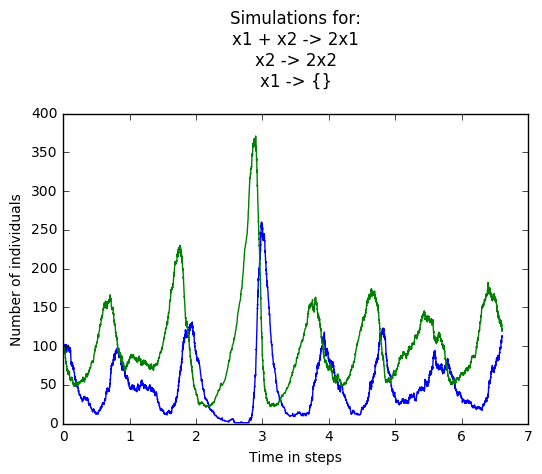

In [55]:
N = 2
M = 3

initstate = np.zeros(N)
initstate[0] = 100 # predator
initstate[1] = 100 # prey

inputs = np.zeros((M, N))
# x1 + x2 ->
inputs[0][0] = 1
inputs[0][1] = 1
# x2 ->
inputs[1][0] = 0
inputs[1][1] = 1
# x1 ->
inputs[2][0] = 1
inputs[2][1] = 0

outputs = np.zeros((M, N))
# -> 2*x1
outputs[0][0] = 2
outputs[0][1] = 0
# -> 2*x2
outputs[1][0] = 0
outputs[1][1] = 2
# -> nothing
outputs[2][0] = 0
outputs[2][1] = 0

numsteps = 10000

def run_scenario_2(initstate, inputs, outputs, rates, numsteps, showPlot):
    #print('initial state:', initstate, '| inputs:', inputs, '| outputs:', outputs, '| rates:', rates, '| numsteps:', numsteps)
    print('rates:', rates, '| numsteps:', numsteps)
    print('----------------------------------------------------------------------------------------------------')
    
    Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
    if showPlot: plt.plot(Thist, Nhist)
        
    print('Predator population: ', Nhist[-1][0])
    print('Prey population: ', Nhist[-1][1])

    if showPlot:
        # Plot the data
        plt.title('Simulations for:\nx1 + x2 -> 2x1\nx2 -> 2x2\nx1 -> {}\n')
        plt.xlabel('Time in steps')
        plt.ylabel('Number of individuals')
        plt.show()


rates = np.array([0.1, 10, 10])         
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2(initstate, inputs, outputs, rates, numsteps, True)      
# Result: TODO:
# beautiful; mostly stable; usually predators would extinct, prey would live, in 20 000 steps; but in 10 000 both would survive        

rates = np.array([0.1, 100, 1]) 
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2(initstate, inputs, outputs, rates, numsteps, True)      
# Result: TODO:
# prey die => predators start to die    

rates = np.array([0.1, 5, 10]) 
# Format: (initstate, inputs, outputs, rates, numsteps, showPlot)    
run_scenario_2(initstate, inputs, outputs, rates, numsteps, True)      
# Result: TODO:
# beautiful; usually predators would extinct, prey would live, in 20 000 steps; but in 10 000 both would survive


# TODO: Plot some more... "Good/interesting behaviour"

#rates = np.array([1, 1, 1]) # predators' steep growth and prey and, therefore, predator populations extinction
# rates = np.array([0.01, 10, 10]) # wouldn't extinct, with 40 000 steps looks like three next, but slower
# rates = np.array([0.1, 10, 5]) # beautiful; both populations extinct
#rates = np.array([0.1, 190, 1]) # equality for this number of steps, but prey populations start to die while predator's — to grow, what will end up as previous run
#rates = np.array([2, 3000, 1]) 

## Task 3: Continuous-state simulation (3 points)

### a) Implement a deterministic ordinary differential equation simulator using the same input as the stochastic simulator above.

Your simulator should follow Eq. (11) in Gillespie (2000) paper. In order to discretise the time, please select a finite time step \tau and apply the Euler discretisation of approximating
$$ \frac{dX(t)}{dt} = f(X(t)) $$
by
$$ X(t + \tau) \approx X(t) + \tau \cdot f(X(t)). $$

* Repeat exercises 1a, 1b and 2b using your simulator. How do the results differ from the original?

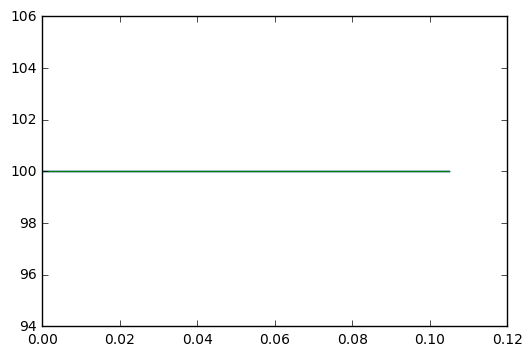

In [66]:
# Suggested skeleton with same arguments as above, except tau is the time step
def simulate_reaction_ode(initstate, inputs, outputs, rates, numsteps, tau):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    v = np.zeros((M, N))
    for j in range(M):
        for i in range(N):
            v[j][i] = outputs[j][i] - inputs[j][i]
    # Implementation of the macroscopic reaction rate equation (Gillespie 2000, equation 11)
    # TODO: Check strange behavior!
    for i in range(numsteps):
        Thist[i+1] = Thist[i] + tau  
        for k in range(N):
            if state[k] < 0:
                state = np.zeros(N)
                rates = np.zeros(M)
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                h[j] *= ssp.binom(state[k], inputs[j][k])
        a = h * rates   # vector with indices [0, .., M-1]
        fx = np.zeros(N)
        for j in range(M):
            fx += v[j] * a[j]
        state += tau * fx
        Nhist[i+1,:] = state
    return (Thist, Nhist)


#1a)
# 5.458 — average time from task 1a. This one, compared to 1a), is 'stable': every run ends up at the same curve, opposite to 1a)
#for i in range(5):
#    Thist, Nhist = simulate_reaction_ode(np.array([100]), np.array([[1]]), np.array([[0]]), np.array([1]), 100, 5.458/100)
#    plt.plot(Thist, Nhist)
#plt.show()

#1b)
#decreasing, since v = [0.8, -1], => fx = h*(0.8 - 1) = h * (-0.2)
#Thist, Nhist = simulate_reaction_ode(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([0.8,1]), 100, 1)
#plt.plot(Thist, Nhist)
#plt.show()

#constant, since v = [1, -1], => fx = h*(1 - 1) = h * 1
# Thist, Nhist = simulate_reaction_ode(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([1,1]), 100, 1)
# plt.plot(Thist, Nhist)
# plt.show()

#increasing, since v = [1.2, -1], => fx = h*(1.2 - 1) = h * 0.2
# Thist, Nhist = simulate_reaction_ode(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([1.2,1]), 100, 1)
# plt.plot(Thist, Nhist)
# plt.show()

#2b)
# only the case with rates=[0.1,10,10] (fx = [0,0]) will be constant
# v tells us that chances of all reactions should be almost equal in order for system to live (fx=[a1-a3, -a1+a2] and state[i] > fx[i] for each i in 0..N-1)
#Thist, Nhist = simulate_reaction_ode(np.array([1, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 10, 10]), 100, 3.5/100)
Thist, Nhist = simulate_reaction_ode(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 10, 10]), 3, 3.5/100)
#Thist, Nhist = simulate_reaction_ode(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.01, 10, 10]), 50000, 50/50000)
#Thist, Nhist = simulate_reaction_ode(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 5, 10]), 50000, 50/50000)
#Thist, Nhist = simulate_reaction_ode(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 10, 7]), 50000, 50/50000)
plt.plot(Thist, Nhist)
plt.show()


### b) Implement a stochastic continuous-state simulator using the same input as above.

Your simulator should follow Eq. (21) of the Gillespie (2000) paper.

* Repeat exercises 1a, 1b and 2b using your simulator. How do the results differ from the original and from 3a?

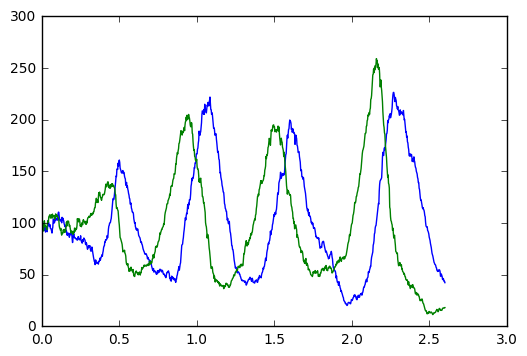

In [8]:
import math
# Suggested skeleton with same arguments as above, except tau is the time step
def simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, tau):
    # Current time and state
    t_cur = 0
    state = 1.0 * initstate.copy()
    N = len(state)
    M = len(rates)
    # State history
    Nhist = np.zeros((numsteps+1, N))
    Nhist[0,:] = state
    # Time history
    Thist = np.zeros(numsteps+1)
    Thist[0] = t_cur
    v = np.zeros((M, N))
    for j in range(M):
        for i in range(N):
            v[j][i] = outputs[j][i] - inputs[j][i]
    
    # ...
    for i in range(numsteps):
        t_cur += tau
        Thist[i+1] = t_cur
        
#         for k in range(N):
#             if state[k] < 0:
#                 state = np.zeros(N)
#                 rates = np.zeros(M)
            
        h = np.ones(M)
        for j in range(M):
            for k in range(N):
                h[j] *= comb(state[k], inputs[j][k])
        a = h * rates  # vector with indices [0, .., M-1]


        fx = np.zeros(N)
        gx = np.zeros(N)
        for j in range(M):
            for k in range(N):
                fx[k] += v[j][k] * a[j] * tau
                gx[k] += v[j][k] * (a[j] * tau)**(1/2) * npr.normal(0,1)

        state += fx + gx
        Nhist[i+1,:] = state
    # ...
    
    return (Thist, Nhist)


#1a)
# 5.458 — average time from task 1a. 
# for i in range(100):
#     Thist, Nhist = simulate_chemical_langevin_eq(np.array([100]), np.array([[1]]), np.array([[0]]), np.array([1]), 100, 5.458/100)
#     plt.plot(Thist, Nhist)
# plt.show()

#1b)
# for i in range(10):
#     Thist, Nhist = simulate_chemical_langevin_eq(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([0.8,1]), 100, 0.25)
#     plt.plot(Thist, Nhist)
# plt.show()

# for i in range(10):
#     Thist, Nhist = simulate_chemical_langevin_eq(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([1,1]), 1000, 0.1)
#     plt.plot(Thist, Nhist)
# plt.show()

# for i in range(10):
#     Thist, Nhist = simulate_chemical_langevin_eq(np.array([100]), np.array([[1],[1]]), np.array([[2],[0]]), np.array([1.2,1]), 100, 0.1)
#     plt.plot(Thist, Nhist)
# plt.show()

#2b)
# Thist, Nhist = simulate_chemical_langevin_eq(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 10, 10]), 10000, 3.5/10000)
Thist, Nhist = simulate_chemical_langevin_eq(np.array([100, 100]), np.array([[1, 1],[0,1],[1,0]]), np.array([[2,0],[0,2],[0,0]]), np.array([0.1, 10, 10]), 1000, 2.6/1000)
plt.plot(Thist, Nhist)
plt.show()


## Task 4: Simulating a system of repression of expression (2 points)

In this task you will implement a simplified model of repressive regulation, a simplified "repressilator". This is more complicated than the predator-prey system in 2b because preventing preduction is not the same as enhancing degradation. (In the predator analogue, predators would only target the young and therefore decrease the birth rate of prey but leave the existing (adult) population intact.

The repressilator model has 3 genes, each of which represses the next in a cycle A -> B -> C -> A. A realistic model would include 6 species to model both mRNAs and protein levels of each gene. In this task we simplify things a bit by combining the mRNA and protein for each gene.

In order to simulate repression, we augment the model by introducing additional states $aX$ and $rX$ that represent "active" and "repressed" promoter states of gene $X \in \{A, B, C\}$. Production of gene $X$ only happens when the promoter is in the active state and the repressor moves the promoter into repressed state. The system can be expressed through reactions:
\begin{align}
aX &\rightarrow aX + 10 X \quad &\text{# transcription} \\
Y + aX &\rightarrow rX &\text{# repression, } Y \text{ is the repressor}\\
rX &\rightarrow aX &\text{# recovery from repression} \\
X &\rightarrow \emptyset &\text{# decay}
\end{align}
These reactions are repeated for all genes, resulting in total 12 reactions for the 9 species in the system.

* Implement the reactions and simulate them using the simulators you implemented in Tasks 2 and/or 3. Use rate 0.1 for the decay equation and rate 1.0 for the others.
* Remember that aX and rX represent different states of the single promoter of a gene, there are not supposed to be many copies of them.
* Repeat the stochastic simulations 100 times and compute the average. Visualise the gene counts from a number of the individual simulations.

     X    aX    rX
A:  [  9.80698812e+01  -6.55928264e-03   1.40336244e+01]
B:  [ 96.97164547   1.0968347   21.77764218]
C:  [ 98.10085902   6.03968008  16.85401723]


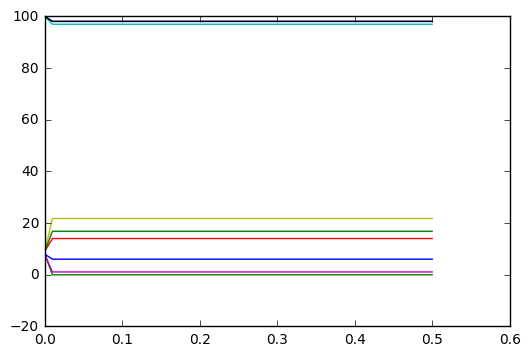

In [25]:
# N = 9
# M = 12

# A,aA,rA, B,aB,rB, C,aC,rC
initstate = np.array([100,8,9, 100,8,9, 100,8,9])

inputs = np.array([
        [0,1,0, 0,0,0, 0,0,0],
        [0,1,0, 0,0,0, 1,0,0],
        [0,0,1, 0,0,0, 0,0,0],
        [1,0,0, 0,0,0, 0,0,0],
        
        [0,0,0, 0,1,0, 0,0,0],
        [1,0,0, 0,1,0, 0,0,0],
        [0,0,0, 0,0,1, 0,0,0],
        [0,0,0, 1,0,0, 0,0,0],
        
        [0,0,0, 0,0,0, 0,1,0],
        [0,0,0, 1,0,0, 0,1,0],
        [0,0,0, 0,0,0, 0,0,1],
        [0,0,0, 0,0,0, 1,0,0]
    ]);

outputs = np.array([
        [10,1,0, 0,0,0, 0,0,0],
        [ 0,0,1, 0,0,0, 0,0,0],
        [ 0,1,0, 0,0,0, 0,0,0],
        [ 0,0,0, 0,0,0, 0,0,0],
        
        [0,0,0, 10,1,0, 0,0,0],
        [0,0,0,  0,0,1, 0,0,0],
        [0,0,0,  0,1,0, 0,0,0],
        [0,0,0,  0,0,0, 0,0,0],
        
        [0,0,0, 0,0,0, 10,1,0],
        [0,0,0, 0,0,0,  0,0,1],
        [0,0,0, 0,0,0,  0,1,0],
        [0,0,0, 0,0,0,  0,0,0]
    ]);

rates = np.array([1,1,1,0.1, 1,1,1,0.1, 1,1,1,0.1])

numsteps = 10000

# from Task2
# final = []
# for i in range(100):
#     Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
#     final.append(Nhist[-1])
#     if i%20 == 0:
#         print('     X    aX    rX')
#         print('A: ', Nhist[-1][0:3])
#         print('B: ', Nhist[-1][3:6])
#         print('C: ', Nhist[-1][6:9])
#         plt.plot(Thist, Nhist)
#         plt.show()
# 
# print('Average for A: ', np.mean([x[0] for x in final]))
# print('Average for aA: ', np.mean([x[1] for x in final]))
# print('Average for rA: ', np.mean([x[2] for x in final]))

# print('\nAverage for B: ', np.mean([x[3] for x in final]))
# print('Average for aB: ', np.mean([x[4] for x in final]))
# print('Average for rB: ', np.mean([x[5] for x in final]))

# print('\nAverage for C: ', np.mean([x[6] for x in final]))
# print('Average for aC: ', np.mean([x[7] for x in final]))
# print('Average for rC: ', np.mean([x[8] for x in final]))
       
# Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
# plt.plot(Thist, Nhist)
# plt.show()

#https://en.wikipedia.org/wiki/Repressilator
    
# from Task3
# A,aA,rA, B,aB,rB, C,aC,rC
#initstate = np.array([100,30,30, 100,30,30, 100,30,30])
# Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
# Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, numsteps, 55/numsteps)
Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, 50, 0.01)
print('     X    aX    rX')
print('A: ', Nhist[-1][0:3])
print('B: ', Nhist[-1][3:6])
print('C: ', Nhist[-1][6:9])
plt.plot(Thist, Nhist)
plt.show()

Bonus task: implement a full repressilator model including both mRNAs and proteins. Try to assign realistic rates for all the reactions. Simulate your model using the simulators you implemented in Tasks 2 and/or 3 and visualise the results.

\begin{align}
aX &\rightarrow aX + 10 mX \quad &\text{# mX — mRNA } \\
mX &\rightarrow \emptyset &\text{# decay of mRNA} \\
mX &\rightarrow X &\text{# producing protein} \\
Y + aX &\rightarrow rX &\text{# repression, } Y \text{ is the repressor}\\
rX &\rightarrow aX &\text{# recovery from repression} \\
X &\rightarrow \emptyset &\text{# decay}
\end{align}

     X    aX    rX    mX
A:  [  43.   17.    0.  122.]
B:  [ 42.   0.  17.  17.]
C:  [ 0.  8.  9.  5.]


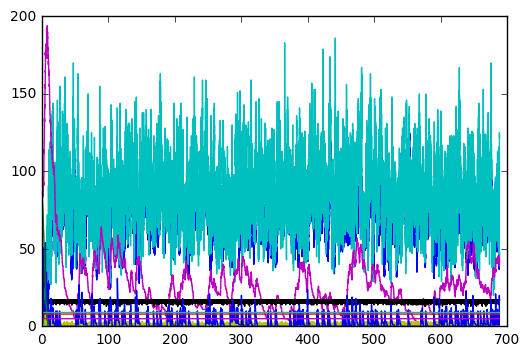

In [47]:
# N = 4 * 3 = 12
# M = 6 * 3 = 18

# A,aA,rA,mA, B,aB,rB,mB, C,aC,rC,mC
initstate = np.array([100,8,9,5, 100,8,9,5, 100,8,9,5])

inputs = np.array([
        [0,1,0,0, 0,0,0,0, 0,0,0,0], # aA -> (aA + 10 mA)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (empty)
        [0,0,0,1, 0,0,0,0, 0,0,0,0], # mA -> (A)
        [0,1,0,0, 0,0,0,0, 1,0,0,0], # C + aA -> (rA)
        [0,0,1,0, 0,0,0,0, 0,0,0,0], # rA -> (aA)
        [1,0,0,0, 0,0,0,0, 0,0,0,0], # A -> (empty)
        
        [0,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [0,0,0,0, 0,0,0,1, 0,0,0,0],
        [1,0,0,0, 0,1,0,0, 0,0,0,0],
        [0,0,0,0, 0,0,1,0, 0,0,0,0],
        [0,0,0,0, 1,0,0,0, 0,0,0,0],
        
        
        [0,0,0,0, 0,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 0,0,0,0, 0,0,0,1],
        [0,0,0,0, 1,0,0,0, 0,1,0,0],
        [0,0,0,0, 0,0,0,0, 0,0,1,0],
        [0,0,0,0, 0,0,0,0, 1,0,0,0]
    ]);

outputs = np.array([
        [0,1,0,10, 0,0,0,0, 0,0,0,0], # (aA) -> aA + 10 mA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> empty
        [1,0,0,0,  0,0,0,0, 0,0,0,0], # (mA) -> A
        [0,0,1,0,  0,0,0,0, 0,0,0,0], # (C + aA) -> rA
        [0,1,0,0,  0,0,0,0, 0,0,0,0], # (rA) -> aA
        [0,0,0,0,  0,0,0,0, 0,0,0,0], # (A) -> empty      
        
        [0,0,0,0, 0,1,0,10, 0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        [0,0,0,0, 1,0,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,1,0,  0,0,0,0],
        [0,0,0,0, 0,1,0,0,  0,0,0,0],
        [0,0,0,0, 0,0,0,0,  0,0,0,0],
        
        [0,0,0,0, 0,0,0,0, 0,1,0,10],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 1,0,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,1,0 ],
        [0,0,0,0, 0,0,0,0, 0,1,0,0 ],
        [0,0,0,0, 0,0,0,0, 0,0,0,0 ]
    ]);

rates = np.array([1,1,1,0.1, 1,1,1,0.1, 1,1,1,0.1])

numsteps = 10000

Thist, Nhist = stochastic_simulation_algorithm(initstate, inputs, outputs, rates, numsteps)
# Thist, Nhist = simulate_chemical_langevin_eq(initstate, inputs, outputs, rates, 50, 0.01)
print('     X    aX    rX    mX')
print('A: ', Nhist[-1][0:4])
print('B: ', Nhist[-1][4:8])
print('C: ', Nhist[-1][8:12])
plt.plot(Thist, Nhist)
plt.show()

## General hints and warnings

* Remember that Python passes function arguments by reference. This means that if you change the argument in a function, it will also change in the caller. If you have a simulator that changes its initial state, you may inadvertedly change its value in the caller too, which may affect future calls if you are running the simulator in a loop. Directly assigning the value to a new variable is not enough because assignments are also by reference.
* The continuous-state simulators can be sensitive to the chosen $\tau$ value. If the simulation is unstable, try decreasing $\tau$.